# Проект по Методам Оптимизации
##### Участники: _Вихрев Евгений, Родионов Дмитрий, Гарнов Юрий_

### Проблема

Требуется минимизировать ранг частично заполненой матрицы.

$E \subset N \times N$ - Множество наблюдаемых значений. \
$M \in Mat_{n,m}$ - Наблюдаемые значения (Б.О.О. $n > m$).

$$ \min_X rank(X),\ subject\ to\ X_{i,j} = M_{i,j} \  \  \forall i, j \in E $$
$$\text{Where } X \in Mat_{n,m},\ n > m \ \ \&\ \  r << n$$

Это NP-трудная задача. Но с некоторыми предположения её можно решить с высокой точностью.

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from algorithms.als_minimization import als_minimization
from algorithms.conv_relax import nuclear_norm_minimization


In [2]:
def create_case(N=100, M=100, est=1000, mode="norm"):
    if mode == "norm":
        A = np.random.randn(N, M)
    elif mode == "linear":
        A = sps.randint.rvs(low=-10, high=10, size=(N, M))
    mask = sps.bernoulli.rvs(est/(N*M), size=(N, M))
    return A, mask


In [ ]:
def als_minimization(A, mask, k=10, mu=1e-6, epsilon=1e-6):
    """
    alternating least squares minimization.
    ---------------------------------------------------------------------
    |   A : m x n array,                                                |
    |       matrix to complete                                          |
    |   mask : m x n array,                                             |
    |       matrix with entries zero (if missing) or one (if present)   |
    |   k : nubmer of left singular vectors to be used,                 |
    |       Rank on the resulting matrix can't be higher than k         |
    |   mu : coefficient of unit vector,                                |
    |       Unit vector is user to estimate minimum of function via     |
    |       solving of system of linear equations                       |
    |   epsilon : criteria of convergence,                              |
    |       We stop calculation if norm of difference of two neibouring |
    |       iteration in less than epsilon                              |
    ---------------------------------------------------------------------
    """

    m, n = A.shape
    max_iterations = 100

    U, _, _ = np.linalg.svd(np.multiply(A, mask))
    U = U[:, :k]
    V = np.zeros((n, k))

    C_u = [np.diag(row) for row in mask]
    C_v = [np.diag(col) for col in mask.T]

    X = np.dot(U, V.T)

    for _ in range(max_iterations):
        for j in range(n):
            V[j] = np.linalg.solve(
                np.linalg.multi_dot([U.T, C_v[j], U]) + mu * np.eye(k),
                np.linalg.multi_dot([U.T, C_v[j], A[:,j]]), )

        for i in range(m):
            U[i] = np.linalg.solve(
                np.linalg.multi_dot([V.T, C_u[i], V]) + mu * np.eye(k),
                np.linalg.multi_dot([V.T, C_u[i], A[i,:]]), )

        new_X = np.dot(U, V.T)

        mean_diff = np.linalg.norm(X - new_X) / m / n
        if mean_diff < epsilon:
            break
        X = new_X

    return new_X


In [3]:
def test_als(runs=5, K=50, est=1000):
    """
    Dimentions of the test matrix is 100x100.
    """
    epsilon = 1e-6
    mu = 1e-6
    N, M = 100, 100

    rank = np.zeros(K)
    max_distance = np.zeros(K)

    for k in range(1, K + 1):
        local_rank = np.zeros(runs)
        local_max_distance = np.zeros(runs)
        for i in range(runs):
            A, mask = create_case(N, M, est)
            X = als_minimization(A, mask, k=k, mu=mu, epsilon=epsilon)
            local_rank[i] = np.linalg.matrix_rank(X)
            local_max_distance[i] = np.max(np.abs(np.multiply(X, mask) - np.multiply(A, mask)))
        rank[k-1] = local_rank.mean()
        max_distance[k-1] = local_max_distance.mean()

    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(np.arange(0, K), rank, label=r'estimated rank')
    plt.plot(np.arange(0, K), max_distance, label=r'estimated max variation')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(np.arange(5, K), max_distance[5:], label=r'estimated max variation')
    plt.legend()
    plt.show()
    

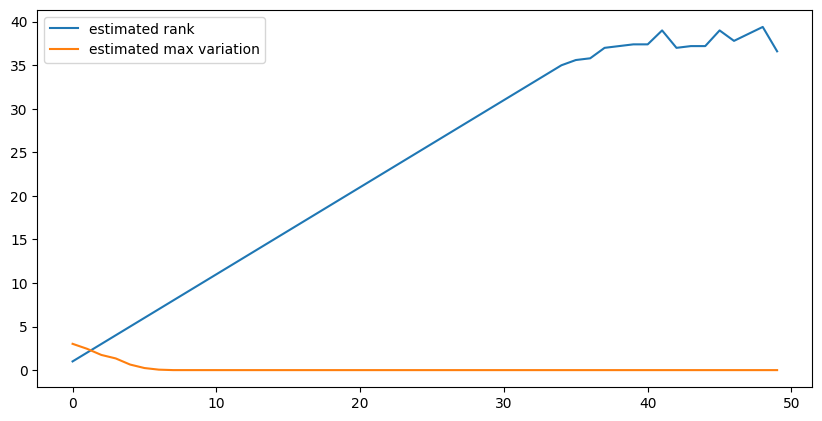

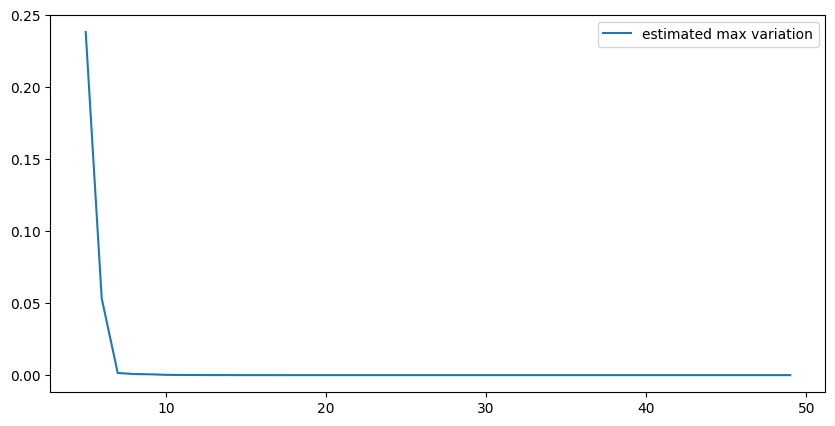

In [4]:
test_als()

Как мы видим _ранг_ возвращаемой алгоритмом натрицы тождественно равна $k$ до $k \sim 35$, после чего значение стабилизуется.

Также, видим что  $max_{i,j \in E} |X_{i,j}-A_{i,j}|$ - максимальный модуль разности $(>Var(X_{i,j}-A_{i,j}\ \ where\ \ i,j \in E))$, в начале имеет большое значение $\sim 3$, но быстро стабилизируется в нуле. Можно считать, что $\min_X rank(X) = min_k (max\_distance_k \sim 0)$. 

Для матриц из теста это $\sim 8$ или $9$.



# Convex relaxation
**Ядерная форма**

Идея следующая - давайте будем минимизировать не ранк матрицы, а ей ядерную норму.

Если мы приведем матрицу в ядерную форму, то она будет выглядеть следующим образом

$ x = U S V^* = \sum_{i=0}^{n-1} s_i u_i v_i^*$

где $S = diag(s_i)_i$ это диагональная матрица сингулярных значений.

$ s_0 \geq \ldots s_{r-1} &gt; 0 \space and \space
            \forall i \geq r, \: s_i=0 $
            
$where \space r=rank(x)$


**Ядерная норма**

${\displaystyle \|A\|_{*}=\operatorname {trace} \left({\sqrt {A^{*}A}}\right)=\sum _{i=1}^{\min\{m,n\}}\sigma _{i}(A),}$

$\sqrt {A^{*}A}$ - положительная полуопределённая матрица B, т.ч. $BB = AA^*$

Ядерная норма является выпуклой (вниз) оболочкой $rank(x)$ и соответственно $min$
ядерная формы будет совпадать с $min(rank)$


In [ ]:
from cvxpy import *
import numpy as np


def floor_singular_values(X, decimals):
    U, sigma, V = np.linalg.svd(X)
    sigma = np.diag(sigma.round(decimals))
    return np.linalg.multi_dot([U, sigma, V.conjugate()])


def nuclear_norm_minimalization(A, mask, value_protection_coefficient=100, decimals=3):
    """
    Convex relaxation via Nuclear Norm Minimization [Candès and Recht approach]
    ---------------------------------------------------------------------
    |   A : m x n array,                                                |
    |       matrix to complete                                          |
    |   mask : m x n array,                                             |
    |       matrix with entries zero (if missing) or one (if present)   |
    |   value_protection_coefficient : significance of sum_squares of   |
    |       multiply(mask, X - A), shows how much constraints enforced  |
    |   decimals : to which decimal place to floor singular values      |
    ---------------------------------------------------------------------
    """
    X = Variable(shape=A.shape)
    objective = Minimize(norm(X, "nuc") + value_protection_coefficient * sum_squares(multiply(mask, X - A)))
    problem = Problem(objective, [])
    problem.solve(solver=SCS)
    return floor_singular_values(X.value, decimals)


In [5]:
def compare_methods():
    results = [[]]
    N=35
    M=35
    sample_count = 3
    
    decimals = np.arange(1, 8)
    ranks = []
    for decim in decimals:

      result = []
      for i in range(sample_count):
        A, mask = create_case(N, M, est=120)
        result.append(np.linalg.matrix_rank(nuclear_norm_minimalization(A, mask, decimals=decim)))

      ranks.append(np.min(result))
    
    plt.figure(figsize=(15, 9))
    plt.title('Зависимость ранга от количества знаков после запятой при округлении.')
    plt.plot(decimals, ranks)
    
compare_methods()

[[-0.17270518 -0.26730862  0.42567572 ...  0.19659901  0.22059444
   0.38908617]
 [ 0.94558211 -0.62724923  0.27623903 ... -0.23670121 -0.25479033
   0.49789792]
 [-0.14698271  0.06131539 -0.56636525 ... -1.5390671   0.24618741
  -0.44100516]
 ...
 [ 0.22572427  0.22215777  0.24542887 ...  0.29848835 -0.54070056
   0.74832894]
 [-0.02187438  0.45527845 -0.05336937 ... -0.20357838 -0.15349666
  -0.31697697]
 [ 0.48550502  0.03466475 -0.28642281 ...  0.23427166  0.49233207
  -0.29530923]]


Алгоритм SVT является продолжением и улучшением идей, предложенными Кандесом и Рехтом
в их подходе к решению LRMCP. В основе лежит та же идея, что вместо минимизаици ранга матрицы
можно минимизировать его нуклеарную норму, но подход другой
Вместо решения оптимизационной задачи предлагается итеративно искать такие величины:
$
\begin{array}{ll}
X^k = shrink(Y^{k-1}, \tau)\textrm{,}\\
Y^k = Y^{k - 1} + \delta_kP_{\Omega}(M - X^k)
\end{array},
$
$ Y^0 = 0\\ $
Где  $\{X^k\}$ и будет последовательностью приближений нашей матрицы к минимальному рангу
        

In [ ]:
def svt_solve(A, mask, tau=None, delta=None, epsilon=1e-2, max_iterations=1000):
    Y = np.zeros_like(A)

    if not tau:
        tau = 5 * np.sum(A.shape) / 2
    if not delta:
        delta = 1.2 * np.prod(A.shape) / np.sum(mask)

    for _ in range(max_iterations):

        U, S, V = np.linalg.svd(Y, full_matrices=False)
        S = np.maximum(S - tau, 0)

        X = np.linalg.multi_dot([U, np.diag(S), V])
        Y += delta * mask * (A - X)

        recon_error = np.linalg.norm(mask * (X - A)) / np.linalg.norm(mask * A)
        if _ % 1 == 0:
          pass
            # print("Iteration: %i; Rel error: %.4f" % (_ + 1, recon_error))
        if recon_error < epsilon:
            break

    return X    

def compare_methods():
    results = [[]]
    N=10
    M=10
    sample_count = 10
    
    decimals = np.arange(1, 15)
    ranks = []
    for decim in decimals:

      result = []
      for i in range(sample_count):
        A, mask = create_case(N, M, est=35)
        result.append(np.linalg.matrix_rank(svt_solve(A, mask, epsilon=1/(10**decim))))

      ranks.append(np.mean(result))
    
    plt.figure(figsize=(15, 9))
    plt.title('Зависимость ранга от величины ошибки')
    plt.plot(decimals, ranks)

    
compare_methods()


Ещё один метод - An Accelerated Proximal Gradient Algorithm (APGL)
 
Подробнее - http://sma.epfl.ch/~anchpcommon/students/michenkova.pdf


In [ ]:
def floor_singular_values(X, tau, decimals):
    U, sigma, V = np.linalg.svd(X)
    sigma = np.maximum(sigma - tau, 0)
    sigma = np.diag(sigma.round(decimals))
    return np.linalg.multi_dot([U, sigma, V.conjugate()])

def apgl(A, mask, max_iterations=1000, epsilon=1e-2):
    t_k = 1
    t_k_minus_one = t_k
    tau = np.linalg.norm(A) / 1000000

    X = A
    Y = A
    X_minus_1 = X
    for i in range(max_iterations):
        Z = X + (t_k_minus_one - 1) / t_k * (X - X_minus_1)
        Y = Z + (mask * (A - Z))
        t_k_minus_one = t_k
        t_k = 0.5 * (1 + (1 + 4 * t_k * t_k) ** 0.5)
       
        X_minus_1 = np.copy(X)
        X = floor_singular_values(Y, tau, 1)
       
        # print(np.linalg.norm(X - X_minus_1) / max([np.linalg.norm(X), 1]))
        if np.linalg.norm(X - X_minus_1) / max([np.linalg.norm(X), 1]) < epsilon:
          print('Reached epsilon on {} iteration'.format(i))
          return X

    return X

def compare_methods():
    results = [[]]
    N=10
    M=10
    sample_count = 10
    
    decimals = np.arange(3, 15)
    ranks = []
    for decim in decimals:

      result = []
      for i in range(sample_count):
        A, mask = create_case(N, M, est=35)
        X = apgl(A, mask, epsilon=1/(10**decim))
        result.append(np.linalg.matrix_rank(X))

      ranks.append(np.mean(result))
    
    plt.figure(figsize=(15, 9))
    plt.title('Зависимость ранга от величины ошибки')
    plt.plot(decimals, ranks)

    
compare_methods()
    

# Полезные ссылки
* http://www.numerical-tours.com/matlab/sparsity_3_matrix_completion/
* https://en.wikipedia.org/wiki/Matrix_completion
* http://sma.epfl.ch/~anchpcommon/students/michenkova.pdf
